In [ ]:
# Some data-handling functions to download/import.

# from https://github.com/yandexdataschool/mlhep2018/blob/master/day2-Tue/seminar-03-keras-cnn/seminar_tf_keras.ipynb
"""I load some cifar"""

import numpy as np
from sklearn.model_selection import train_test_split
import os, sys
if sys.version_info[0] == 2:
    from urllib import urlretrieve
    import cPickle as pickle

else:
    from urllib.request import urlretrieve
    import pickle

def unpickle(file):
    fo = open(file, 'rb')
    if sys.version_info[0] == 2:
        dict = pickle.load(fo)
    else:
        dict = pickle.load(fo,encoding='latin1')

    fo.close()
    return dict




def download_cifar10(path,
                     url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                     tarname='cifar-10-python.tar.gz',):
    import tarfile
    if not os.path.exists(path):
        os.mkdir(path)



    urlretrieve(url, os.path.join(path,tarname))
    tfile = tarfile.open(os.path.join(path,tarname))
    tfile.extractall(path=path)


def load_cifar10(data_path=".",channels_last=False,test_size=0.2,random_state=1337):

    test_path = os.path.join(data_path,"cifar-10-batches-py/test_batch")
    train_paths = [os.path.join(data_path,"cifar-10-batches-py/data_batch_%i"%i) for i in range(1,6)]

    if not os.path.exists(test_path) or not all(list(map(os.path.exists, train_paths))):
        print ("Dataset not found. Downloading...")
        download_cifar10(data_path)

    train_batches = list(map(unpickle,train_paths))
    test_batch = unpickle(test_path)

    X = np.concatenate([batch["data"] for batch in train_batches]).reshape([-1,3,32,32]).astype('float32')/255
    y = np.concatenate([batch["labels"] for batch in train_batches]).astype('int32')
    X_train,X_val,y_train,y_val = train_test_split(X,y,
                                                   test_size=test_size,
                                                   random_state=random_state)

    X_test = test_batch["data"].reshape([-1,3,32,32]).astype('float32')/255
    y_test = np.array(test_batch["labels"]).astype('int32')

    if channels_last:
        #convert from [batch,3,H,W] to [batch,H,W,3]
        #WARNING! Make this is only necessary for tensorflow-style dim order
        #If you use theano-style dimensions in keras config, skip this cell
        X_train = X_train.transpose([0,2,3,1])
        X_val   = X_val.transpose([0,2,3,1])
        X_test  = X_test.transpose([0,2,3,1])


    return X_train,y_train,X_val,y_val,X_test,y_test

In [ ]:
import tensorflow as tf
#gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.1) # restricts GPU load for multi-user nodes

import tensorflow.keras as keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

2.18.0
3.8.0


In [ ]:
# Load the data samples

x_train,y_train,x_val,y_val,x_test,y_test = load_cifar10("cifar_data",channels_last=True)

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer",
                   "dog", "frog", "horse", "ship", "truck"]

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)
print("Val samples:", x_val.shape, y_val.shape)

Train samples: (40000, 32, 32, 3) (40000,)
Test samples: (10000, 32, 32, 3) (10000,)
Val samples: (10000, 32, 32, 3) (10000,)


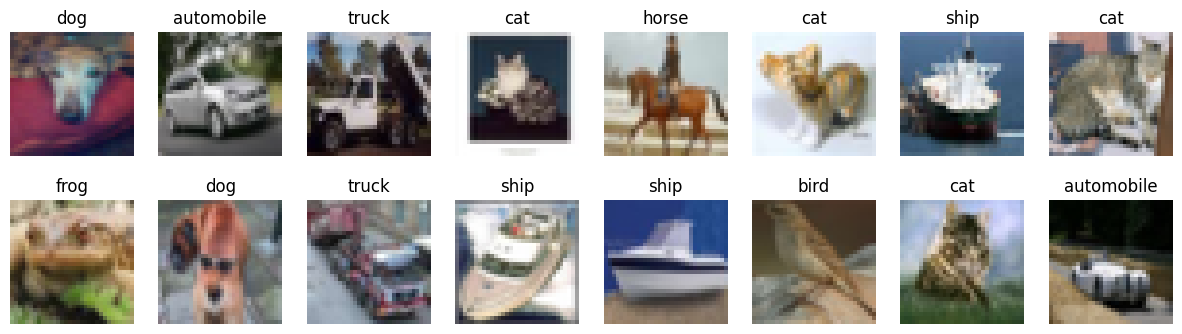

In [ ]:
# show some random images from train, and their labels

cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index]])
plt.show()

In [ ]:
# normalize inputs
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
# x_train = x_train.astype(np.float64) - 0.5

y_train = keras.utils.to_categorical(y_train, num_classes=10)

y_val = keras.utils.to_categorical(y_val, num_classes=10)

y_test = keras.utils.to_categorical(y_test, num_classes=10)

In [ ]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.layers import LeakyReLU

In [ ]:
def make_model():


    model = Sequential()



    # First convolutional block with 2 convolutional layers (3x3 kernel)
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same')) #CNN layer with 32 neurons
    model.add(BatchNormalization()) #Batch Normalization for stabilization
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))#Second convolutional layer
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2))) #Pooling layer to help the network focus on the most important patterns (2x2 kernel)
    model.add(Dropout(0.25)) #Dropout layer to randomly deactivate some neurons to avoid overfitting

    # Second convolutional block with 2 convolutional layers (3x3 kernel)
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same')) #CNN layer with 64 neurons
    model.add(BatchNormalization()) #Batch Normalization for stabilization
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same')) #Second convolutional layer
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))#Pooling layer to help the network focus on the most important patterns (2x2 kernel)
    model.add(Dropout(0.25)) #Dropout layer to randomly deactivate some neurons to avoid overfitting

    # Third convolutional block with 2 convolutional layers (3x3 kernel)
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same')) #CNN layer with 128 neurons
    model.add(BatchNormalization()) #Batch Normalization for stabilization
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same')) #Second convolutional layer
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2))) #Pooling layer to help the network focus on the most important patterns (2x2 kernel)
    model.add(Dropout(0.25)) #Dropout layer to randomly deactivate some neurons to avoid overfitting


    # Flatten the data and put into a one dimensional vector (layer with only numbers)
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Final output layer for the ten classes
    model.add(Dense(10, activation='softmax'))



    return model



To begin, the neural network takes color images and we process  the color images with three convolutional layers which consist of kernels. the data is then normalised. Then a pooling layer is used to reduce the size of the feature maps. It basically makes the formation of the image by taking the biggest value in all the small regions.

Then, for the model to learn more features and not just memorize specific patterns, a dropout layer is used to turn off some of the neurons. This process is repeated with many more neurons, for the model to get more and more complex features. The first block has 32 filters, the second has 64, and the third has 128.


After the convolutional layers, all the features that the model has learned are flattened out into a one-dimensional vector. To learn even more complex features, the one-dimensional vector is passed into a connected layer with 512 neurons, which mixes the features together.

Lastly, a dense layer with 10 neuros and a softmax activation, detects simple details and slowly combines them together and comverts them into probabilities for the 10 classes to decide what category the image falls into.


In [ ]:
### STUDENT CODE HERE ###
### --> change the parameters below to perform a better training


INIT_LR = 1e-3 #Learning rate, to determine the speed at which the model updates its weights during learning process (the smaller it is, the smaller the adjustments)
BATCH_SIZE = 32 #Number of samples the model processes before changing its weights
EPOCHS = 15 #Epochs is the number of times the model goes through the learning process.


K.clear_session()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)

model = make_model()

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.Adamax(learning_rate=INIT_LR),  # for SGD.
    metrics=['accuracy']   # report accuracy during training
)


# fit model
history = model.fit(
    x_train, y_train,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    shuffle=True,

)


# save weights to file to avoid re-training
model.save_weights("myweights.weights.h5")

Epoch 1/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.3255 - loss: 2.2776 - val_accuracy: 0.5096 - val_loss: 1.4358
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5135 - loss: 1.3929 - val_accuracy: 0.6217 - val_loss: 1.0963
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6161 - loss: 1.0971 - val_accuracy: 0.6828 - val_loss: 0.8927
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6691 - loss: 0.9395 - val_accuracy: 0.7177 - val_loss: 0.7931
Epoch 5/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7058 - loss: 0.8378 - val_accuracy: 0.7566 - val_loss: 0.7019
Epoch 6/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.7351 - loss: 0.7640 - val_accuracy: 0.7620 - val_loss: 0.6667
Epoch 7/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7524 - loss: 0.7034 - val_accuracy: 0.7716 - val_loss: 0.6476
Epoch 8/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7719 - loss: 0.6

In [ ]:
# load weights from file (can call without model.fit)
model.load_weights("myweights.weights.h5")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


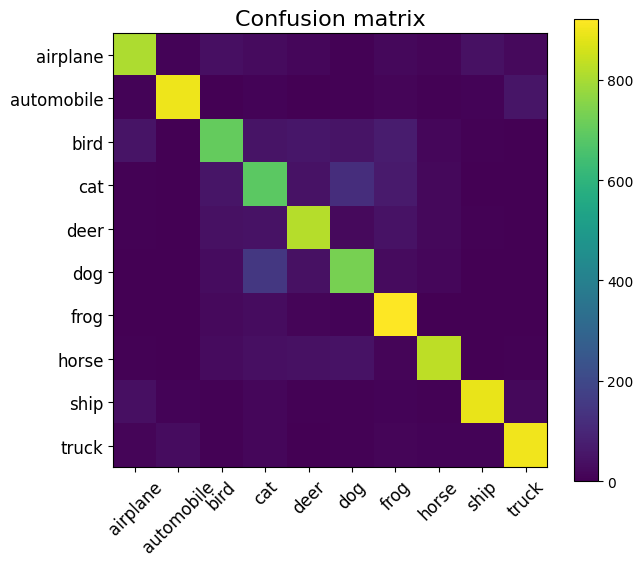

Test accuracy: 0.8178


In [ ]:
# make test predictions
y_pred_test = model.predict(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
y_test_index = [list(onehot).index(1) for onehot in y_test]

# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test_index, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test_index, y_pred_test_classes))

The Test accuracy of the Confusion Matrix is of 81.78%.
A clear diagonal from the blocks can be observed in the matrix.
The model is also constant with its results, this is shown by the colors of the blocks which are mostly in the green/yellow shade, which as seen in the scale on the right hand side, those colors range between 600 up to the max.
We can also obseve that the model did have some more difficulties distinguishing between cats and dogs, and an automobile and a truck. This could be due to the fact that the model was focusing more on the colors rather than the shape.

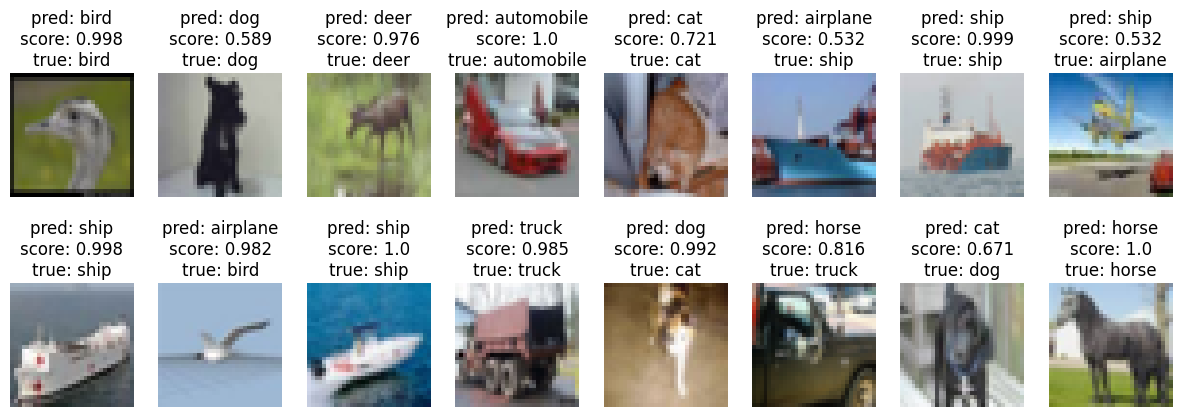

In [ ]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test_index[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

For this part of the code, random pictures are chosen from our test to show how good the model is at predicting what object is shown in the picture. By looking at the predictions we can cocnlude that the model is pretty good at learning new features.

However, for some, it might have learnt to focus on the wrong features. For example, for the picture of the bird or ship, the model predicted that they were both airplanes. this might be due to the fact that it is focusing more on the colors rather than the shape of the object.  

# Some tips on how to improve:

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.

## Potential grading:
* starting at zero points
* +2 for describing your iteration path in a report below.
* +2 for building a network that gets above 20% accuracy
* +1 for beating each of these milestones on __TEST__ dataset:
    * 50% (5 total)
    * 60% (6 total)
    * 65% (7 total)
    * 70% (8 total)
    * 75% (9 total)
    * 80% (10 total)

## Bonus points
Common ways to get bonus points are:
* Get higher score, obviously.
* Anything special about your NN. For example \"A super-small/fast NN that gets 80%\" gets a bonus.
* Any detailed analysis of the results. (saliency maps, whatever)


## Tips on what can be done:

 * __Network size__
   * More neurons,
   * More layers, ([lasagne docs](http://lasagne.readthedocs.org))
   * Nonlinearities in the hidden layers
   * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

 * __Convolution layers__
   * they __are a must__ unless you have any super-ideas
   * `network = lasagne.layers.Conv2DLayer(prev_layer,`
     `                       num_filters = n_neurons,`
     `                       filter_size = (filter width, filter height),`
     `                       nonlinearity = some_nonlinearity)`
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment to try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.

   * Plenty other layers and architectures
     * http://lasagne.readthedocs.org/en/latest/modules/layers.html
     * batch normalization, pooling, etc


 * __Early Stopping__
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum


 * __Faster optimization__ -
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (lasagne.layers.batch_norm) FTW!


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   * Dropout - to prevent overfitting
     * `lasagne.layers.DropoutLayer(prev_layer, p=probability_to_zero_out)`   
     * Don't overdo it. Check if it actually makes your network better


 * __Data augmentation__ - getting 5x as large dataset for free is a great deal
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Add Noize (easiest: GaussianNoizeLayer)
   * Simple way to do that (if you have PIL/Image):
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.


